In [51]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import qr

# Constants


In [52]:
noise_probability = 0.8

Q_qubits = 1
A_qubits = 2
B_qubits = 2

Q_wires = list(range(Q_qubits))
A_wires = list(range(Q_qubits, Q_qubits + A_qubits))
B_wires = list(range(Q_qubits + A_qubits, Q_qubits + A_qubits + B_qubits))

dim = 2 ** (Q_qubits + A_qubits)

alpha_length = 18
beta_length = 38
test_alpha = np.random.uniform(0, np.pi, size=(alpha_length,))
test_beta = np.random.uniform(0, np.pi, size=(beta_length,))

#Quantum Device
dev = qml.device('default.mixed', wires=Q_qubits + A_qubits + B_qubits)

# Gradient Descent 
stepsize = 0.01
momentum = 0.95

# Number of iterations
num_its = 500

# Number of simulations
num_sim = 5

# Baseline Fidelity
f_0 = 0.822

# Unitary matrix to test
U = np.array([[-0.78870348+0.60115948j, -0.12800607-0.0129827j ],
        [-0.08447598-0.09704594j, -0.03577956+0.99104274j]])

# $\hat{V}_{QA}$

In [53]:
def prepare_Q(U, wires):
    """Prepares Q into the quantum state defined by the unitary U

    Args:
        U (array[complex]): the matrix U to apply to the fiduciary quantum state of Q
        wires (array[int]): the wires representing Q. If Q is a single-qubit, then this should be an array of length 1.
    """
    qml.QubitUnitary(U, wires)

In [54]:
def prepare_V_QA(alpha, wires):
    """Prepares the V_QA parametric gate given the vector alpha for a Q with k=1 qubits

    Args:
        alpha (array[complex]): The alpha vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, and wires[1..2] shoudl represent A
    """
    # First two gates for each wire
    qml.RY(alpha[0], wires=wires[0])
    qml.RX(alpha[1], wires=wires[0])

    qml.RY(alpha[6], wires=wires[1])
    qml.RX(alpha[7], wires=wires[1])

    qml.RY(alpha[12], wires=wires[2])
    qml.RX(alpha[13], wires=wires[2])

    # Controlled on wire 0
    qml.CRX(alpha[8], wires=[wires[0], wires[1]])
    qml.CRX(alpha[14], wires=[wires[0], wires[2]])

    # Controlled on wire 1
    qml.CRX(alpha[2], wires=[wires[1], wires[0]])
    qml.CRX(alpha[15], wires=[wires[1], wires[2]])

    # Controlled on wire 2
    qml.CRX(alpha[3], wires=[wires[2], wires[0]])
    qml.CRX(alpha[9], wires=[wires[2], wires[1]])

    # Last two gates for each wire
    qml.RY(alpha[4], wires=wires[0])
    qml.RX(alpha[5], wires=wires[0])

    qml.RY(alpha[10], wires=wires[1])
    qml.RX(alpha[11], wires=wires[1])

    qml.RY(alpha[16], wires=wires[2])
    qml.RX(alpha[17], wires=wires[2])

# $\hat{W}_{QAB}$

In [55]:
def prepare_W_QAB(beta, wires):
    """Prepares the W_QAB parametric gate given the vector beta for a Q with k=1 qubits

    Args:
        beta (array[complex]): The beta vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, wires[1..2] should represent A, and wires[3..4] should represent B
    """
    # First two gates for each wire
    qml.RY(beta[0], wires=wires[0])
    qml.RX(beta[1], wires=wires[0])

    qml.RY(beta[10], wires=wires[1])
    qml.RX(beta[11], wires=wires[1])

    qml.RY(beta[20], wires=wires[2])
    qml.RX(beta[21], wires=wires[2])

    qml.RY(beta[30], wires=wires[3])
    qml.RX(beta[31], wires=wires[3])

    qml.RY(beta[34], wires=wires[4])
    qml.RX(beta[35], wires=wires[4])

    # Controlled on wire 3
    qml.CRX(beta[2], wires=[wires[3], wires[0]])
    qml.CRZ(beta[3], wires=[wires[3], wires[0]])

    qml.CRX(beta[12], wires=[wires[3], wires[1]])
    qml.CRZ(beta[13], wires=[wires[3], wires[1]])

    qml.CRX(beta[22], wires=[wires[3], wires[2]])
    qml.CRZ(beta[23], wires=[wires[3], wires[2]])

    # Controlled on wire 4
    qml.CRX(beta[4], wires=[wires[4], wires[0]])
    qml.CRZ(beta[5], wires=[wires[4], wires[0]])

    qml.CRX(beta[14], wires=[wires[4], wires[1]])
    qml.CRZ(beta[15], wires=[wires[4], wires[1]])

    qml.CRX(beta[24], wires=[wires[4], wires[2]])
    qml.CRZ(beta[25], wires=[wires[4], wires[2]])

    # Middle rotation gates for each wire
    qml.RY(beta[6], wires=wires[0])
    qml.RX(beta[7], wires=wires[0])

    qml.RY(beta[16], wires=wires[1])
    qml.RX(beta[17], wires=wires[1])

    qml.RY(beta[26], wires=wires[2])
    qml.RX(beta[27], wires=wires[2])

    qml.RY(beta[22], wires=wires[3])
    qml.RX(beta[23], wires=wires[3])

    qml.RY(beta[36], wires=wires[4])
    qml.RX(beta[37], wires=wires[4])

    # Controlled to apply on wire 0
    qml.ctrl(qml.RZ(beta[8], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])
    qml.ctrl(qml.RX(beta[9], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])

    # Controlled to apply on wire 1
    qml.ctrl(qml.RZ(beta[18], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])
    qml.ctrl(qml.RX(beta[19], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])

    # Controlled to apply on wire 2
    qml.ctrl(qml.RZ(beta[28], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])
    qml.ctrl(qml.RX(beta[29], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])

### Logic diagram of $\hat{V}_{QA}$ and $\hat{W}_{QAB}$

In [56]:
Q_wires= [0]
A_wires = [1,2]
B_wires = [3,4]
dev = qml.device('default.mixed', wires=len(Q_wires) + len(A_wires) + len(B_wires))

@qml.qnode(dev)
def test_V_QA(alpha):
    prepare_V_QA(alpha, Q_wires + A_wires)
    return qml.state()

@qml.qnode(dev)
def test_W_QAB(beta):
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    return qml.state()

(<Figure size 1300x400 with 1 Axes>, <Axes: >)

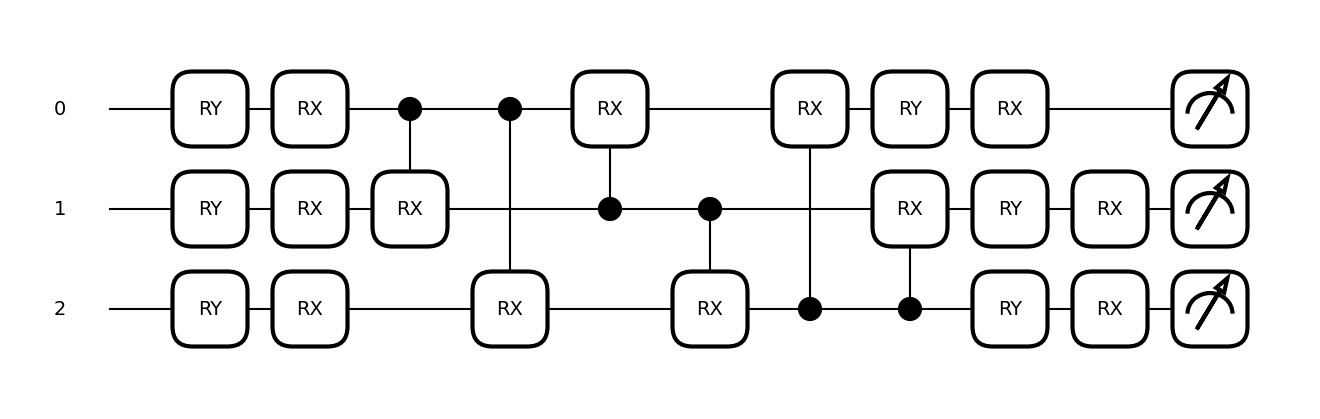

In [57]:
qml.draw_mpl(test_V_QA)(test_alpha)

(<Figure size 2500x600 with 1 Axes>, <Axes: >)

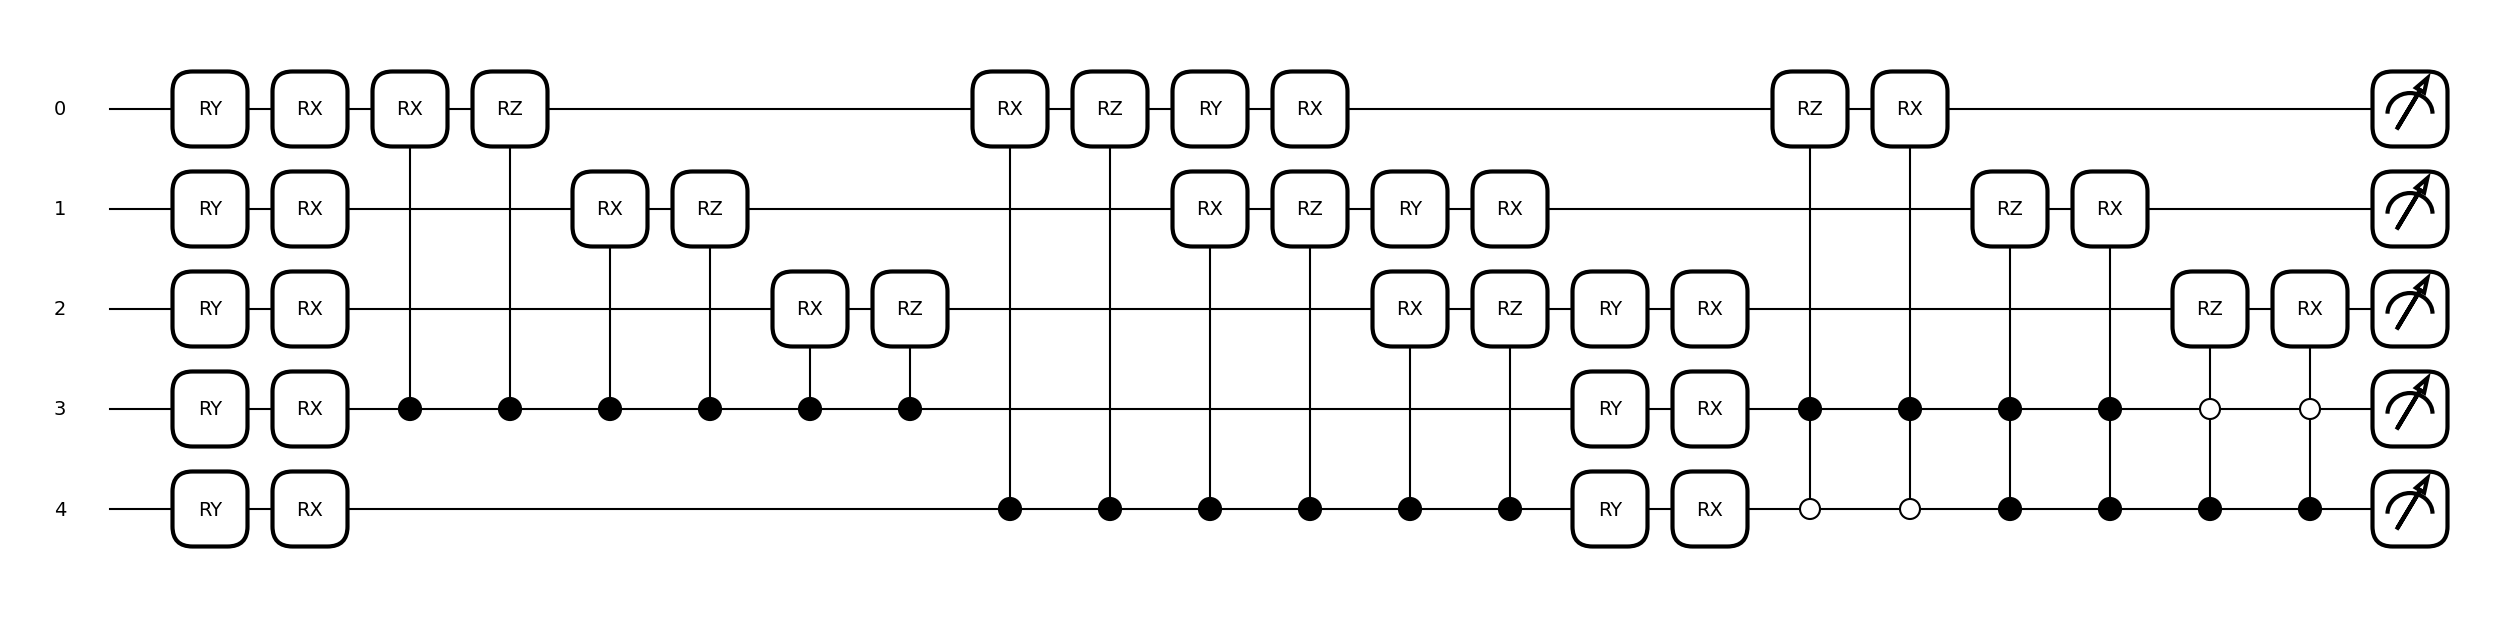

In [58]:
qml.draw_mpl(test_W_QAB)(test_beta)

# Calculate Hamiltonians for Fidelity and Wasserstein

In [59]:
# Get the fidelity hamiltonian matrix from the 0 state
@qml.qnode(dev)
def fiduciary_density(wires):
    return qml.density_matrix(wires)

#Calculate the hamiltonian for the fiduciary cost
H_QA_fid = np.identity(dim) - fiduciary_density(Q_wires + A_wires)

def wass_hamiltonian():
    H_wass = np.zeros((dim, dim))
    for i in range (1, dim):
        vec = np.zeros((dim, 1))
        vec[i, 0] = 1
        
        # Binary 011, 101, 110
        if i == 3 or i == 5 or i == 6:
            density_mat = 2 * np.outer(vec, vec.T)
        # Binary 111
        elif i == 7:
            density_mat = 3 * np.outer(vec, vec.T)
        # Binary 001, 010, 100
        else:
            density_mat = np.outer(vec, vec.T)
            
        H_wass += density_mat
    return H_wass

H_QA_wass = wass_hamiltonian()

# Define Kraus Operators for Noise

In [119]:
phase_K0 = np.sqrt(1 - noise_probability) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
phase_K1 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.PauliZ.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
phase_K2 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.PauliZ.compute_matrix()), qml.Identity.compute_matrix())
phase_K3 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.PauliZ.compute_matrix())

phaseflip_kraus_ops = [phase_K0, phase_K1, phase_K2, phase_K3]

bit_K0 = np.sqrt(1 - noise_probability) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
bit_K1 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.PauliX.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
bit_K2 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.PauliX.compute_matrix()), qml.Identity.compute_matrix())
bit_K3 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.PauliX.compute_matrix())

bitflip_kraus_ops = [bit_K0, bit_K1, bit_K2, bit_K3]


# Implementation of the VQA returning the density matrix for fidelity calculations

In [60]:
@qml.qnode(dev)
def fidelity_density(U, alpha, beta, bitFlip=True):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])
    
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    return qml.density_matrix(wires=[0,1,2])
    

@qml.qnode(dev)
def wasserstein_density(U, alpha, beta, bitFlip=True):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])

    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    
    return qml.density_matrix(wires=[0,1,2])

# Implementation of the VQA returning the density matrix after unitary

In [61]:
dev_pure = qml.device('deafult.qubit', wires=Q_qubits + A_qubits + B_qubits)
@qml.qnode(dev_pure)
def unitary_density(U, alpha, beta):
    # prepare_Q(U, Q_wires)
    # prepare_V_QA(alpha, Q_wires + A_wires)
    # prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    # qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    # qml.adjoint(prepare_Q)(U, Q_wires)
    
    return qml.state(wires=[0,1,2])

# Implementation of the VQA returning the cost

In [62]:
@qml.qnode(dev)
def VQA_fidelity(U, alpha, beta, bitFlip=True):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])
    
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    return qml.expval(qml.Hermitian(H_QA_fid, wires=[0,1,2]))
    

@qml.qnode(dev)
def VQA_wasserstein(U, alpha, beta, bitFlip=True):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])

    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    
    return qml.expval(qml.Hermitian(H_QA_wass, wires=[0,1,2]))

# Cost Function (Fidelity)

In [63]:
def fidelity_cost_bitflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_fidelity(U, alpha, beta, True)

    return compute_cost

In [64]:
def fidelity_cost_phaseflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_fidelity(U, alpha, beta, False)

    return compute_cost

In [65]:
def wasserstein_cost_bitflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_wasserstein(U, alpha, beta, True)
    
    return compute_cost

In [66]:
def wasserstein_cost_phaseflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_wasserstein(U, alpha, beta, False)
    
    return compute_cost

# Reproducing Results

In [67]:
def simulation(alpha, beta, U, momentum, noiseModel, calculate_density, bitFlip):
    opt = qml.MomentumOptimizer(stepsize, momentum)

    running_costs = []

    iterations = 0

    while iterations < num_its:
        (alpha, beta), _cost = opt.step_and_cost(noiseModel(U), alpha, beta)
        running_costs.append(_cost)
        
        if _cost < 1e-5:
            break
        
        iterations += 1

    initialDensity = unitary_density(U, alpha, beta)
    finalDensity = calculate_density(U, alpha, beta, bitFlip)
    fidelity = qml.math.fidelity(initialDensity, finalDensity)
    
    return alpha, beta, iterations, fidelity


In [68]:
def qr_haar(N):
    """Generate a Haar-random matrix using the QR decomposition."""
    # Step 1
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    # Step 2
    Q, R = qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    # Step 4
    return np.dot(Q, Lambda)

In [69]:
unitaries = [qr_haar(2) for i in range(num_sim)]

## Bitflip results

In [70]:
fidelityIterations = []
fidelityFidelity = []

for i in range(num_sim):
    _, _, iterations, fidelity = simulation(test_alpha, test_beta, unitaries[i], momentum, fidelity_cost_bitflip_noise, fidelity_density, True)

    if fidelity > f_0:
        fidelityIterations.append(iterations)
        fidelityFidelity.append(fidelity)


In [71]:
wassIterations = []
wassFidelity = []

for i in range(num_sim):
    _, _, iterations, fidelity = simulation(test_alpha, test_beta, unitaries[i], momentum, wasserstein_cost_bitflip_noise, wasserstein_density, True)

    if fidelity > f_0:
        wassIterations.append(iterations)
        wassFidelity.append(fidelity)


In [72]:
print(wassIterations)
print(wassFidelity)

print(fidelityIterations)
print(fidelityFidelity)

[500, 500, 375, 500, 500]
[0.9995427107496135, 0.9997560417974954, 0.9999933237213684, 0.9999806731093461, 0.9996771525178116]
[500, 500, 500, 500, 438]
[0.9975113950705045, 0.9995302210968623, 0.9998911807469003, 0.9992236962685429, 0.9999908627860604]


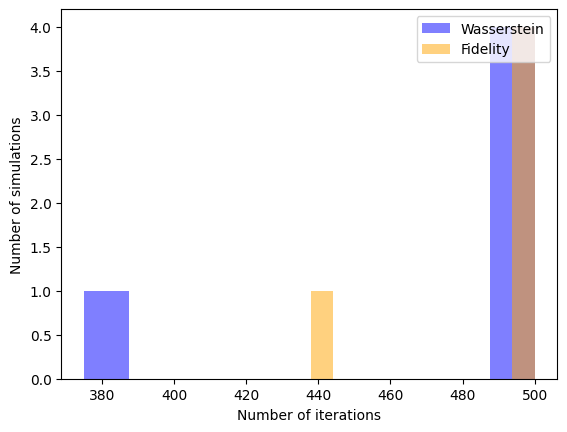

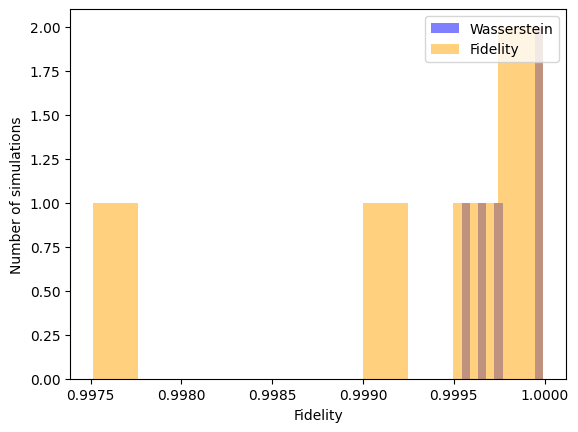

In [73]:
plt.hist(wassIterations, color='blue', label='Wasserstein', alpha=0.5)
plt.hist(fidelityIterations, color='orange', label='Fidelity', alpha=0.5)

plt.xlabel("Number of iterations")
plt.ylabel("Number of simulations")
plt.legend(loc='upper right')
plt.show()

plt.hist(wassFidelity, color='blue', label='Wasserstein', alpha=0.5)
plt.hist(fidelityFidelity, color='orange', label='Fidelity', alpha=0.5)
plt.xlabel("Fidelity")
plt.ylabel("Number of simulations")
plt.legend(loc='upper right')
plt.show()

## Phaseflip Results

In [ ]:
fidelityIterations = []
fidelityFidelity = []

for i in range(num_sim):
    _, _, iterations, fidelity = simulation(test_alpha, test_beta, U, momentum, fidelity_cost_phaseflip_noise, fidelity_density, False)

    if fidelity > f_0:
        fidelityIterations.append(iterations)
        fidelityFidelity.append(fidelity)


In [ ]:
wassIterations = []
wassFidelity = []

for i in range(num_sim):
    _, _, iterations, fidelity = simulation(test_alpha, test_beta, U, momentum, wasserstein_cost_phaseflip_noise, wasserstein_density, False)

    if fidelity > f_0:
        wassIterations.append(iterations)
        wassFidelity.append(fidelity)


In [ ]:
plt.hist(wassIterations, color='blue', label='Wasserstein', alpha=0.5)
plt.hist(fidelityIterations, color='orange', label='Fidelity', alpha=0.5)

plt.xlabel("Number of iterations")
plt.ylabel("Number of simulations")
plt.legend(loc='upper right')
plt.show()

plt.hist(wassFidelity, color='blue', label='Wasserstein', alpha=0.5)
plt.hist(fidelityFidelity, color='orange', label='Fidelity', alpha=0.5)
plt.xlabel("Fidelity")
plt.ylabel("Number of simulations")
plt.legend(loc='upper right')
plt.show()

## Wasserstein then Fidelity

In [ ]:
fidelityDiff = []
for i in range(num_sim):
    wassAlpha, wassBeta, _, wassFidelity = simulation(test_alpha, test_beta, U, momentum, wasserstein_cost_phaseflip_noise, wasserstein_density, False)

    _, _, _, fidelityFidelity = simulation(wassAlpha, wassBeta, U, momentum, fidelity_cost_phaseflip_noise, fidelity_density, False)

    fidelityDiff.append(fidelityDiff - wassFidelity)



plt.hist(fidelityDiff, color='blue')

plt.xlabel("Fidelity")
plt.ylabel("Number of simulations")
plt.show()

## Fidelity then Wasserstein

In [ ]:
fidelityDiff = []
for i in range(num_sim):
    fidelityAlpha, fidelityBeta, _, fidelityFidelity = simulation(test_alpha, test_beta, test_U, momentum, fidelity_cost_phaseflip_noise, fidelity_density, False)

    _, _, _, fidelityFidelity = simulation(fidelityAlpha, fidelityBeta, U, momentum, wasserstein_cost_phaseflip_noise, wasserstein_density, False)

    fidelityDiff.append(fidelityDiff - fidelityFidelity)


plt.hist(fidelityDiff, color='orange')

plt.xlabel("Fidelity")
plt.ylabel("Number of simulations")
plt.show()